## Testing Articulos-v3

In [10]:
%load_ext autoreload
%autoreload 2
import json

with open("../../dumps/coronavirus-argentina-v3.json") as f:
    arts = json.load(f)
    
with open("../../dumps/coronavirus-argentina-v2.json") as f:
    old_arts = json.load(f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
len(arts), len(old_arts)

(74550, 55110)

In [12]:
arts[0].keys()

dict_keys(['_id', 'tweet_id', 'text', 'slug', 'title', 'url', 'user', 'body', 'created_at', 'comments'])

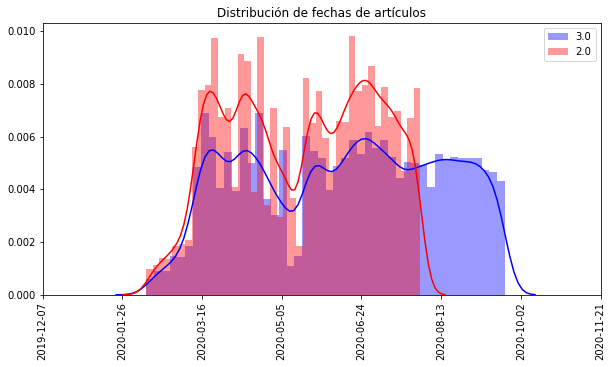

In [13]:
from hate_collector.plot import distplot_dates
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))

distplot_dates([d["created_at"]["$date"] for d in arts], color="blue", label="3.0")
distplot_dates([d["created_at"]["$date"] for d in old_arts], color="red", label="2.0")
plt.legend()

plt.title("Distribución de fechas de artículos");
plt.savefig("distribucion_fechas_3.0.png")

Casi dos meses más de datos

Fecha mínima: 10 de Febrero de 2020

Fecha máxima: 22 de Sept   de 2020


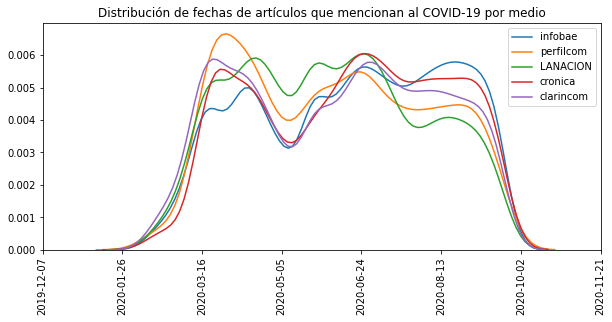

In [14]:
from collections import defaultdict
import datetime

dates_by_newspaper = defaultdict(list)

for art in arts:
    date = datetime.datetime.strptime(art["created_at"]["$date"], "%Y-%m-%dT%H:%M:%SZ")
    dates_by_newspaper[art["user"]].append(date)
    

plt.figure(figsize=(10, 5))

for newspaper, dates in dates_by_newspaper.items():
    distplot_dates(dates, label=newspaper, hist=False)

    
plt.legend()

plt.gcf().subplots_adjust(bottom=0.25)
plt.title("Distribución de fechas de artículos que mencionan al COVID-19 por medio");

plt.savefig("fechas_por_medios.png")


Hay un problema con `La Nación`?

In [15]:
dates = [datetime.datetime.strptime(art["created_at"]["$date"], "%Y-%m-%dT%H:%M:%SZ") for art in arts]


min(dates), max(dates)

(datetime.datetime(2020, 2, 10, 0, 0, 39),
 datetime.datetime(2020, 9, 22, 15, 53, 10))

In [16]:
dates = [datetime.datetime.strptime(art["created_at"]["$date"], "%Y-%m-%dT%H:%M:%SZ") for art in old_arts]


min(dates), max(dates)

(datetime.datetime(2020, 2, 10, 0, 0, 39),
 datetime.datetime(2020, 7, 31, 19, 2, 57))

In [17]:
from collections import Counter

counter = Counter(art["user"] for art in arts)
old_counter = Counter(art["user"] for art in old_arts)

keys = sorted(counter.keys())

for k in counter:
    ratio = counter[k] / old_counter[k]
    diff = counter[k] - old_counter[k]
    print(f"{k:<10} -- {counter[k]:<5} -- Antes: {old_counter[k]:<5} (+{diff:<5}) -- {ratio * 100:.2f}")

infobae    -- 26986 -- Antes: 18987 (+7999 ) -- 142.13
perfilcom  -- 5639  -- Antes: 4363  (+1276 ) -- 129.25
LANACION   -- 10231 -- Antes: 8178  (+2053 ) -- 125.10
cronica    -- 11574 -- Antes: 8392  (+3182 ) -- 137.92
clarincom  -- 20120 -- Antes: 15190 (+4930 ) -- 132.46


In [18]:
from mongoengine import connect
from hatespeech_models import Tweet, Article

client = connect("hatespeech-news")
db = client["hatespeech-news"]


article_ids = [art["tweet_id"] for art in arts]

missing_articles = Tweet.objects(
    user_name="lanacion", 
    in_reply_to_status_id=None,
    retweeted_status=None,
    id__nin=article_ids
).order_by("-created_at")

print(f"Faltan {missing_articles.count()} artículos de La Nación")

Faltan 9189 artículos de La Nación


In [19]:
for tw in missing_articles[:50]:
    print("="*80)
    print("\n")
    print(tw.text)



Dólar. Sube pese a que los bancos no pueden venderlo https://t.co/IaHFxoXbCp https://t.co/oSk7Cy4CjE


Licencia. Los jueces desplazados suman presión antes de la reunión de la Corte https://t.co/cTzOaU1mTB https://t.co/fTlCyJqwGc


AOC: un día de campaña con la legisladora millennial que es furor https://t.co/FezoLiPiax https://t.co/5vyiYI76DL


Triste coincidencia: atropelló a un hombre y luego se enteró que era su suegro https://t.co/BchrA0DTKA https://t.co/666aXHWKwk


Medio ambiente. La historia detrás de la foto del ratón en la bota https://t.co/G2jY6tEQtN @LNnaturaleza https://t.co/tCIz8LJycZ


Murió Ramona Galarza, la dama del chamamé, a los 80 años https://t.co/Rbc8wIdMcH https://t.co/0dt4J0fFd1


Traslados de jueces. El Gobierno pide al Consejo ajustar las vacantes https://t.co/3do9FTECsh https://t.co/rwBPHAwdnL


Viajes en avión. Quién gana cuando compramos un pasaje https://t.co/jCKiSuTOLw https://t.co/A6q9wdRTxK


No tenían permiso para circular y le dieron una paliza al 

Juan, sos tonto? ES QUE NO LOS AGARRA EL FILTRO